In [23]:
#imports & settings
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model      import LinearRegression
from sklearn.model_selection   import train_test_split
from sklearn.metrics           import mean_squared_error, r2_score
from sklearn.preprocessing     import StandardScaler
import warnings
warnings.filterwarnings("ignore")
sns.set_theme()  # nicer default style

In [24]:
#load your three CSVs
stats_df  = pd.read_csv("advanced_player_stats_checked.csv")
raw_df    = pd.read_csv("nba_player_stats_checked.csv")
salary_df = pd.read_csv("nba_salary_checked.csv")

print("Shapes:", stats_df.shape, raw_df.shape, salary_df.shape)
print("Stats columns:", stats_df.columns.tolist())
print("Raw  columns:", raw_df.columns.tolist())
print("Salarycols:", salary_df.columns.tolist())

Shapes: (735, 29) (745, 31) (563, 10)
Stats columns: ['Rk', 'Player', 'Age', 'Team', 'Pos', 'G', 'GS', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Awards']
Raw  columns: ['Rk', 'Player', 'Age', 'Team', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Awards']
Salarycols: ['Rk', 'Player', 'Tm', '2024-25', '2025-26', '2026-27', '2027-28', '2028-29', '2029-30', 'Guaranteed']


In [25]:
#merge on Player only
merged = stats_df.merge(raw_df, on="Player", how="inner", suffixes=("_adv","_raw"))
merged = merged.merge(salary_df, on="Player", how="left")
print("Merged shape:", merged.shape)

Merged shape: (863, 68)


In [26]:
#clean salary (first non-null season), drop $/commas
salary_cols = ["2024-25","2025-26","2026-27","2027-28","2028-29","2029-30"]
# pick first non-null
merged["Salary_raw"] = merged[salary_cols].bfill(axis=1).iloc[:,0]
merged = merged.dropna(subset=["Salary_raw"])
merged["Salary"] = (
    merged["Salary_raw"].replace(r"[\$,]","",regex=True)
                      .astype(float)
)
# drop helpers
merged.drop(columns=salary_cols+["Salary_raw"], inplace=True)
print("After salary clean:", merged.shape)

After salary clean: (811, 63)


In [27]:
#convert object‐dtypes that look numeric (% or numbers) into numeric
for col in merged.columns:
    if merged[col].dtype == "object":
        # strip $ and % then attempt numeric
        tmp = merged[col].str.replace(r"[\$,%]","",regex=True)
        merged[col] = pd.to_numeric(tmp, errors="ignore")

In [28]:
# confirm we have numeric columns & non‐empty
numeric_cols = merged.select_dtypes(include=np.number).columns.tolist()
print("Numeric columns:", numeric_cols)
print(merged[numeric_cols].info())
print(merged[numeric_cols].describe().T)

Numeric columns: ['Rk_adv', 'Age_adv', 'G_adv', 'GS_adv', 'MP_adv', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Awards_adv', 'Rk_raw', 'Age_raw', 'G_raw', 'GS_raw', 'MP_raw', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Rk', 'Guaranteed', 'Salary']
<class 'pandas.core.frame.DataFrame'>
Index: 811 entries, 0 to 861
Data columns (total 56 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Rk_adv      811 non-null    int64  
 1   Age_adv     811 non-null    int64  
 2   G_adv       811 non-null    int64  
 3   GS_adv      811 non-null    int64  
 4   MP_adv      811 non-null    int64  
 5   PER         811 non-null    float64
 6   TS%         806 non-null    float64
 7   3PAr        806 non-null    float64
 8   FTr         806 non-

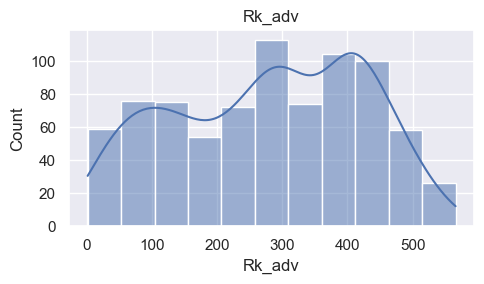

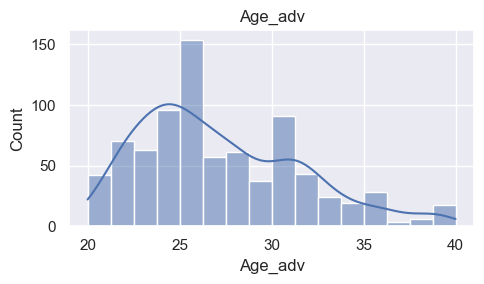

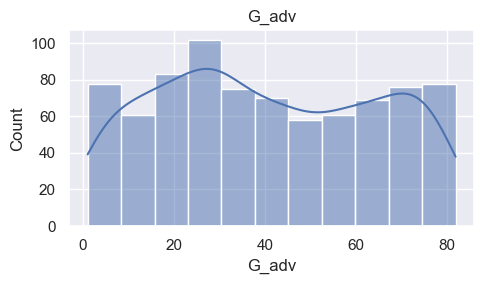

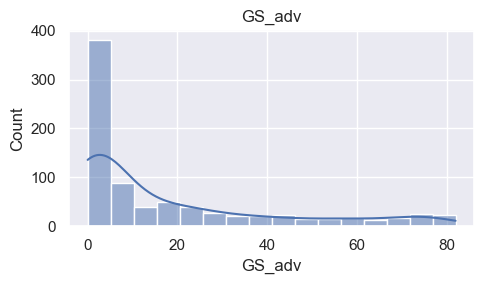

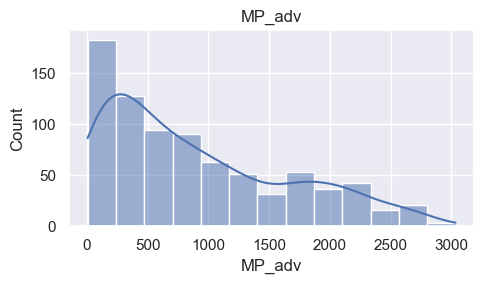

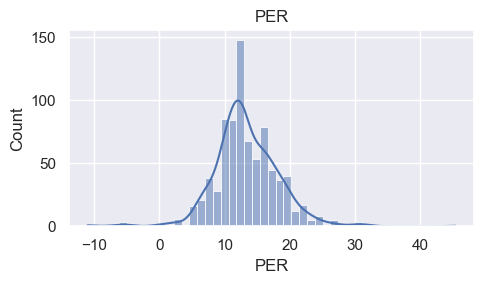

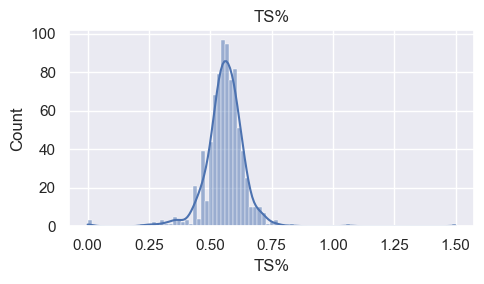

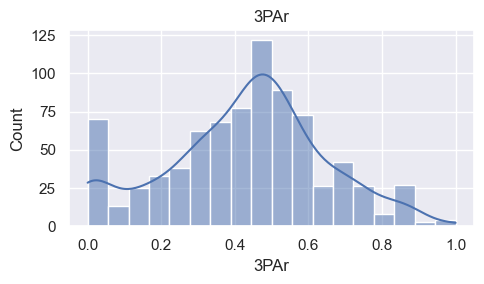

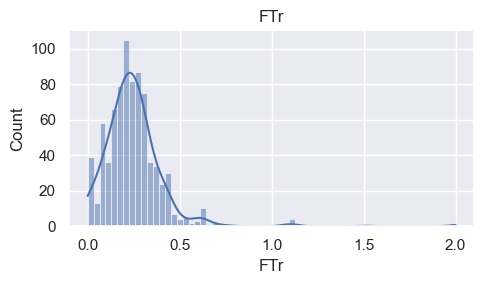

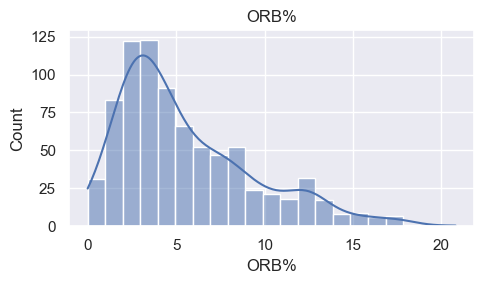

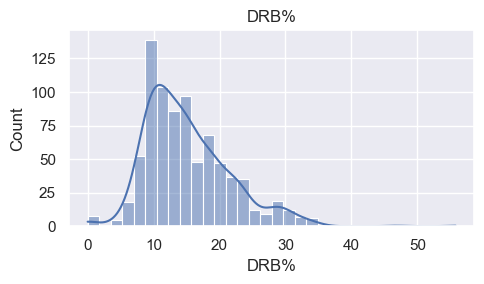

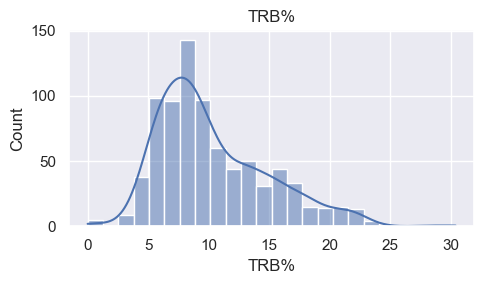

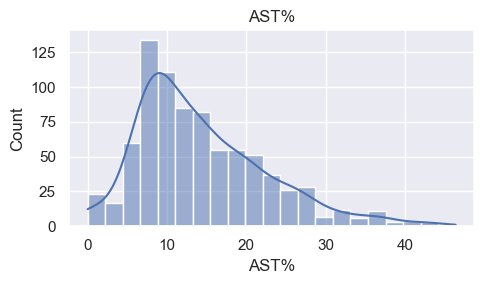

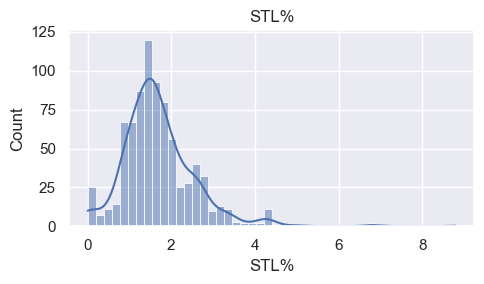

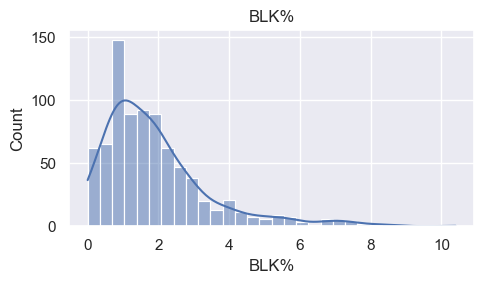

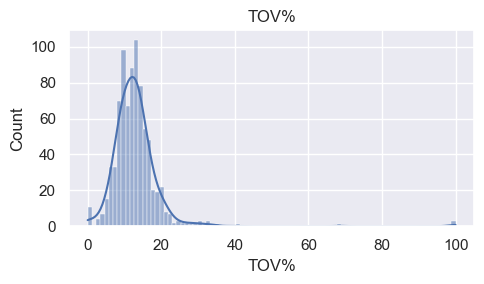

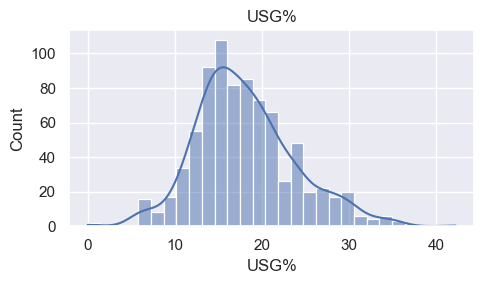

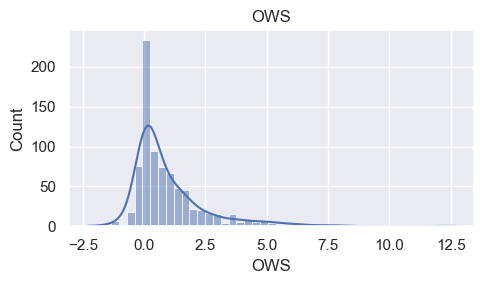

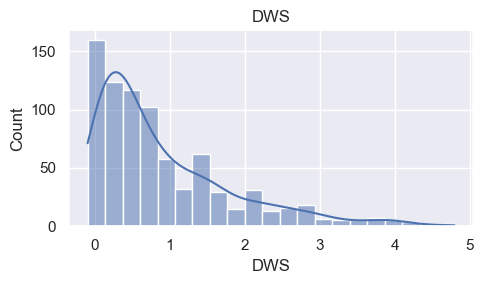

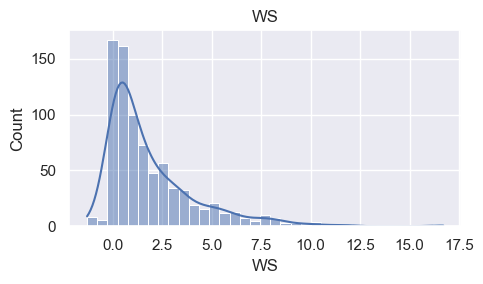

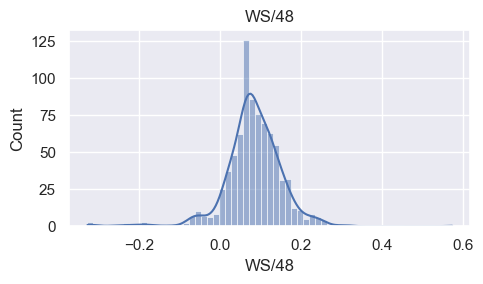

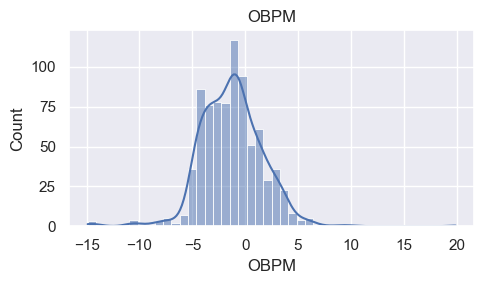

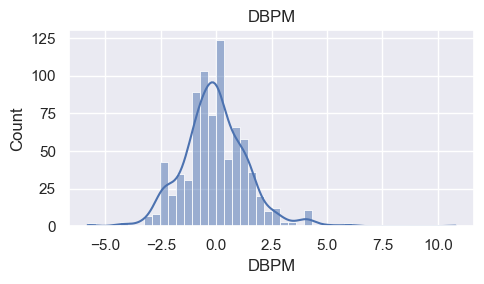

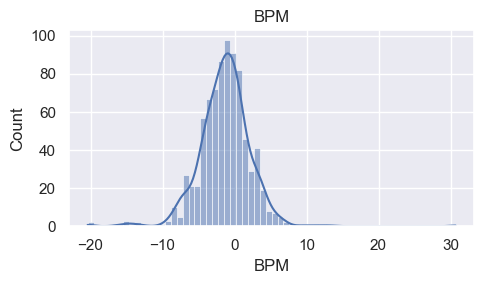

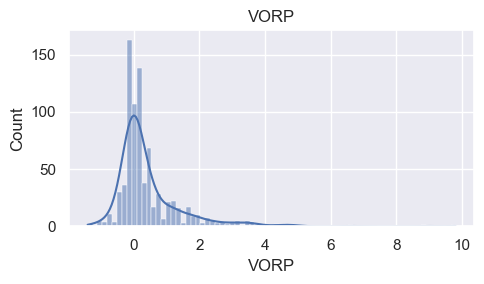

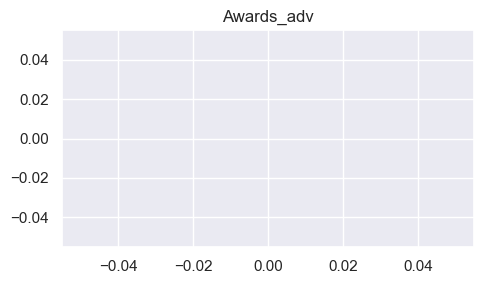

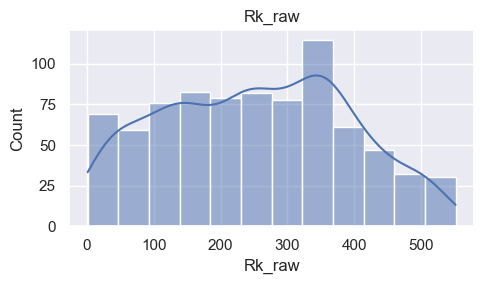

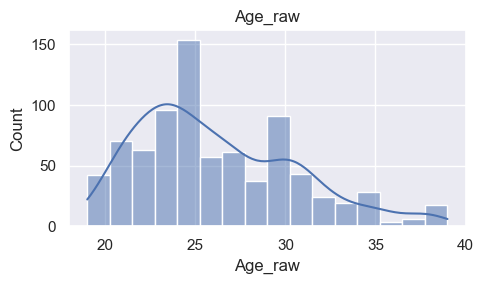

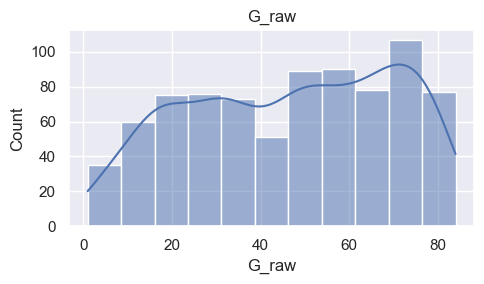

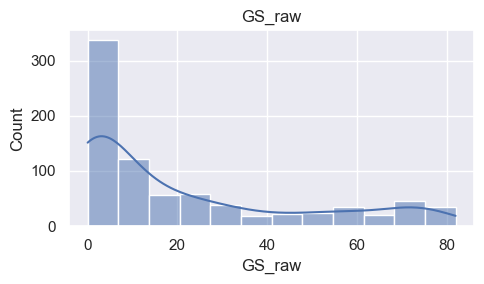

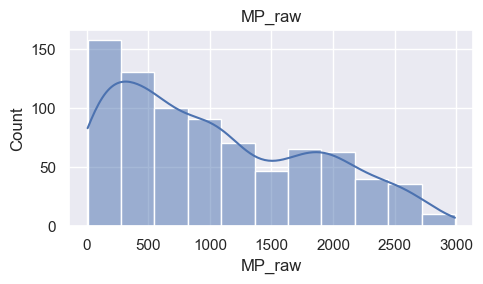

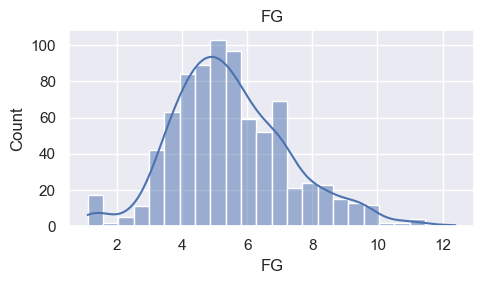

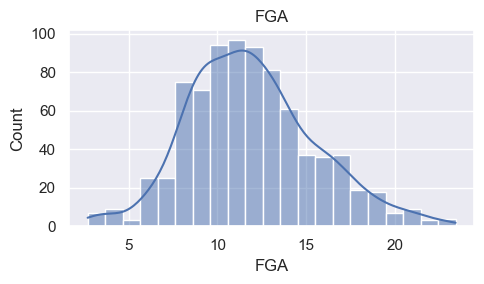

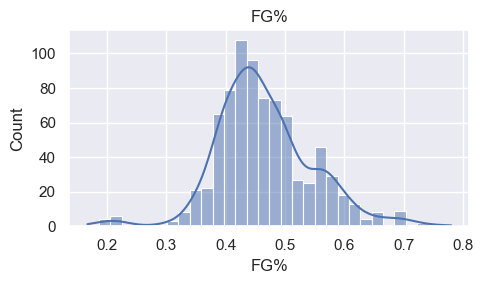

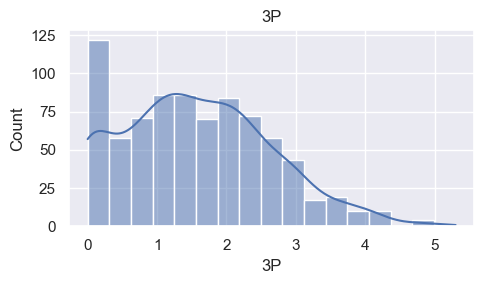

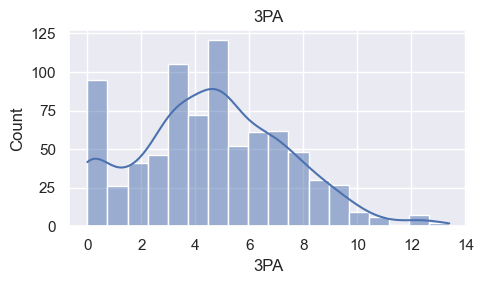

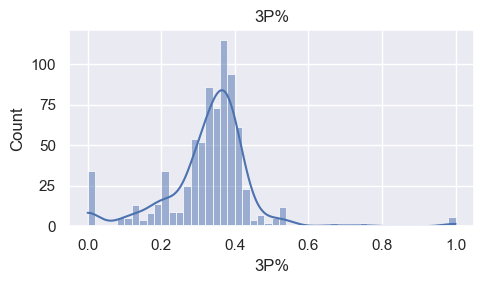

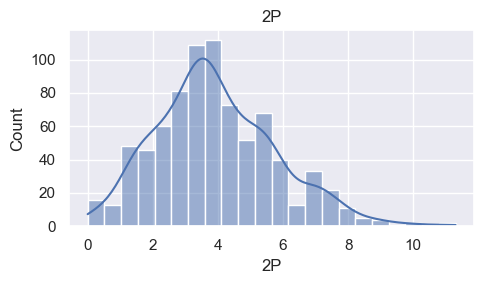

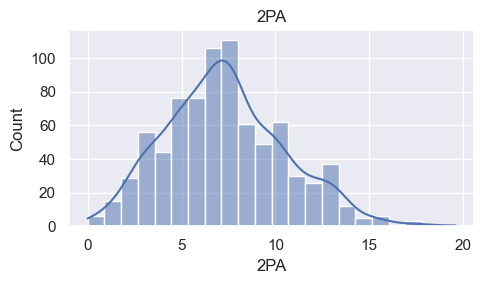

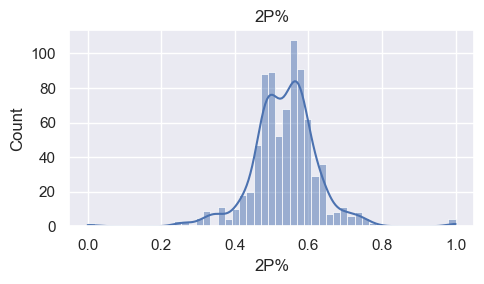

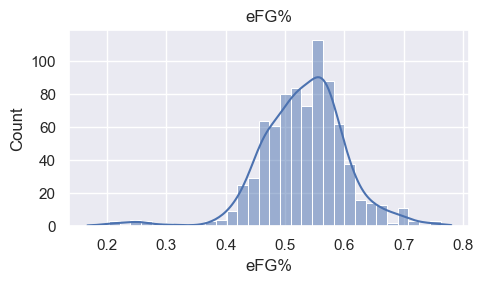

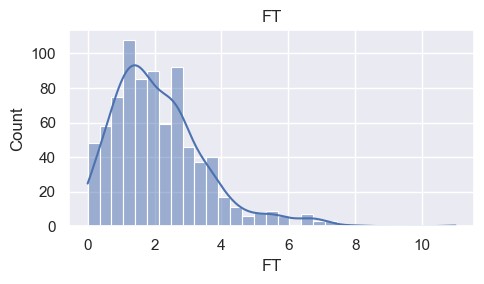

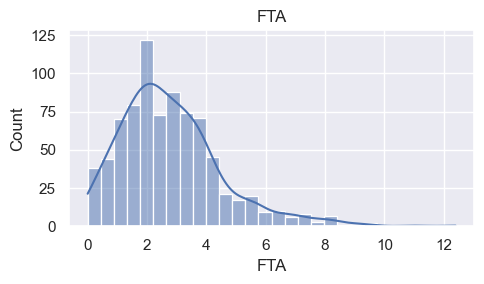

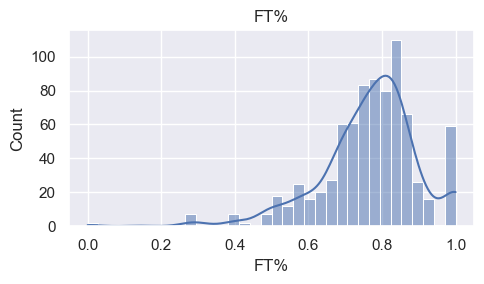

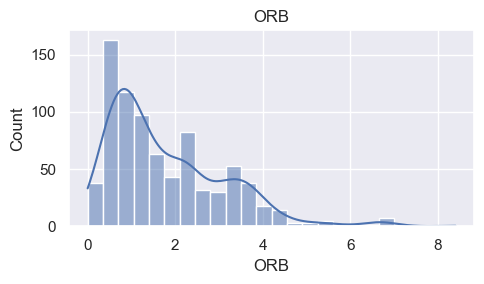

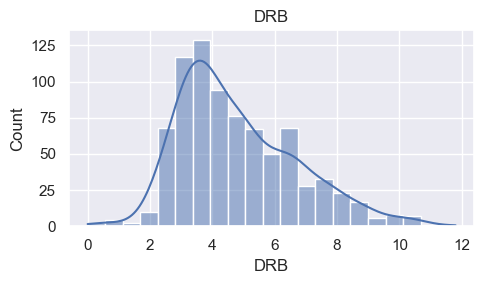

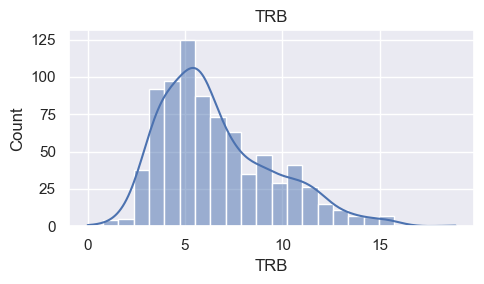

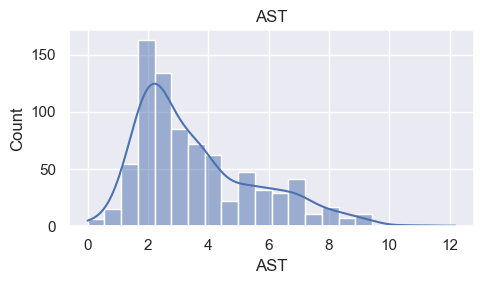

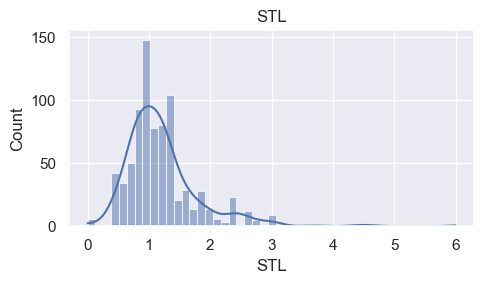

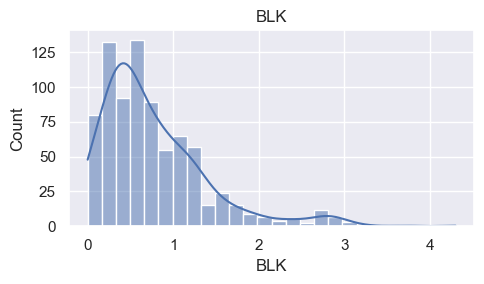

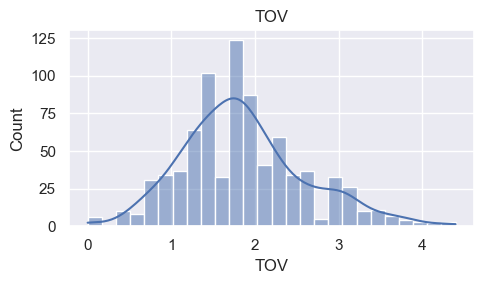

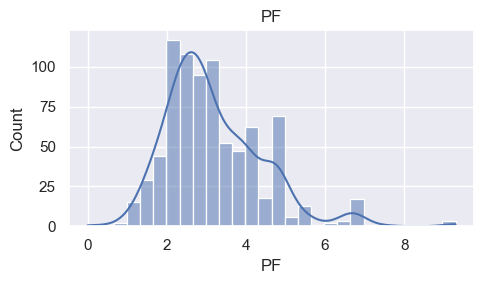

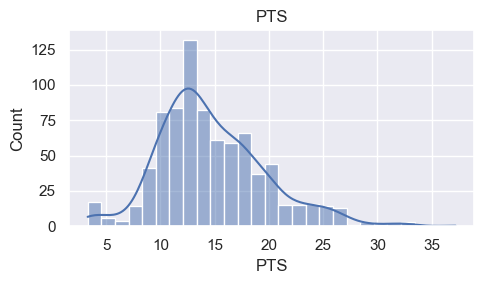

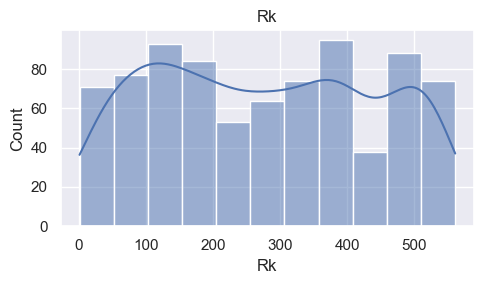

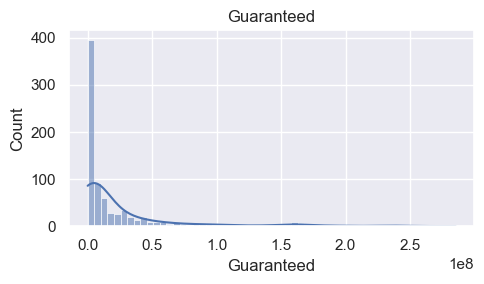

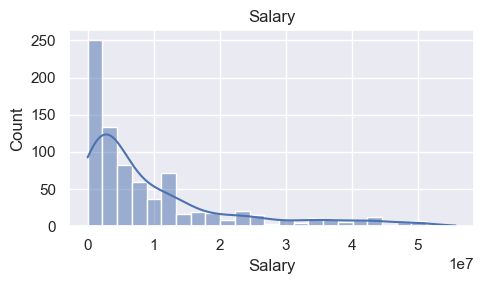

In [29]:
# Cell 7: histograms of every numeric feature
for col in numeric_cols:
    plt.figure(figsize=(5,3))
    sns.histplot(merged[col].dropna(), kde=True)
    plt.title(col)
    plt.tight_layout()
    plt.show()

In [ ]:
#pairplot of first 8 numeric features
sns.pairplot( merged[numeric_cols[:8]].dropna(), corner=True )
plt.suptitle("Pairs (first 8 nums)", y=1.02)
plt.show()

In [ ]:
#correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(merged[numeric_cols].corr(), cmap="coolwarm", center=0, annot=False)
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()

In [ ]:
#Pearson & t-test (PER vs Salary) if they exist
if "PER" in merged and "Salary" in merged:
    r, p_r = stats.pearsonr(merged["PER"], merged["Salary"])
    print(f"Pearson PER→Salary: r={r:.2f}, p={p_r:.3g}")
    m = merged["PER"].mean()
    high = merged.loc[merged["PER"]>m, "Salary"]
    low  = merged.loc[merged["PER"]<=m,"Salary"]
    t, p_t = stats.ttest_ind(high, low, equal_var=False)
    print(f"T-test high vs low PER salary:  t={t:.2f}, p={p_t:.3g}")

In [ ]:
#Linear model (raw features)
feats = [c for c in ["PER","TS%","WS","VORP"] if c in merged]
X = merged[feats].dropna()
y = merged.loc[X.index,"Salary"]
Xtr,Xte,ytr,yte = train_test_split(X,y, test_size=0.2, random_state=1)
lr = LinearRegression().fit(Xtr,ytr)
yp = lr.predict(Xte)
print("Raw model R²=", r2_score(yte,yp), "RMSE=", np.sqrt(mean_squared_error(yte,yp)))

In [ ]:
#Standardize + re-model
scaler  = StandardScaler().fit(X)
X_s     = pd.DataFrame(scaler.transform(X), columns=feats, index=X.index)
Xtr,Xte,ytr,yte = train_test_split(X_s,y, test_size=0.2, random_state=1)
lr2 = LinearRegression().fit(Xtr,ytr)
yp2 = lr2.predict(Xte)
print("Std model R²=", r2_score(yte,yp2), "RMSE=", np.sqrt(mean_squared_error(yte,yp2)))

In [ ]:
#actual vs predicted (standardized)
plt.figure(figsize=(5,5))
plt.scatter(yte, yp2, alpha=0.7)
plt.plot([yte.min(),yte.max()],[yte.min(),yte.max()],"r--")
plt.xlabel("actual sal"); plt.ylabel("pred sal")
plt.tight_layout()
plt.show()

In [22]:
#conclusion
print("""
Done EDA:
- Histograms, pairplot & heatmap for all numeric features
- PER vs Salary: Pearson r & t-test printed above
- Linear regression raw & standardized printed above
""")


Done EDA:
- Histograms, pairplot & heatmap for all numeric features
- PER vs Salary: Pearson r & t-test printed above
- Linear regression raw & standardized printed above

